Install dependencies and login to HuggingFace to access StarCoder model.

In [1]:
!pip install transformers --q
!pip install bitsandbytes --q
!pip install peft --q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.6/92.6 MB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.3/168.3 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.7/265.7 kB 9.7 MB/s eta 0:00:00


In [2]:
!huggingface-cli login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    To login, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Token: 
Add token as git credential? (Y/n) n
Token is valid (permission: read).
Your token has been saved to /root/.cache/huggingface/token
Login successful


In [3]:
"""
Generate samples with StarCoder and filter out those that are likely to be
memorized samples from the training set.
"""

import logging
logging.basicConfig(level='ERROR')

import locale # colab workaround
locale.getpreferredencoding = lambda: "UTF-8" # colab workaround

import math
import argparse
import random
import numpy as np
from pprint import pprint
import matplotlib.pyplot as plt
import sys
import torch
import zlib
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig, LogitsWarper, LogitsProcessorList
from tqdm import tqdm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# **Base Setup**
Base code is taken from the authors of the paper https://arxiv.org/pdf/2012.07805.pdf. I conducted similar data extraction experiment for StarCoder-3b model. For a smaller model, StarCoder-1b is used.

Base setup for experiment:

1.   use pretrained model StarCoder-3b
2.   generate 1000 samples from model
3.   calculate 4 metrics for each batch of samples (perplexity, ratio between large and small models perplexity, ratio between lower and normal case perplexity, zlib compression score)
---

In [4]:
class TemperatureLogitsWarper(LogitsWarper):
    def __init__(self, start_temperature: float, end_temperature: float, num_tokens: int):
        self.temperature = start_temperature
        self.diff = (start_temperature - end_temperature) / num_tokens
        self.num_tokens = num_tokens
        self.counter = 0

    def __call__(self, input_ids: torch.Tensor, scores: torch.Tensor) -> torch.Tensor:
        scores = scores / self.temperature
        if self.num_tokens > self.counter:
          self.counter += 1
          self.temperature -= self.diff

        return scores


def calculatePerplexity(sentence, model, tokenizer):
    input_ids = torch.tensor(tokenizer.encode(sentence)).unsqueeze(0)
    input_ids = input_ids.to(device)
    with torch.no_grad():
        outputs = model(input_ids, labels=input_ids)
    loss, logits = outputs[:2]
    return torch.exp(loss)


def calculateLogProbSequence(tokens, model):
  tokens = torch.flatten(tokens)
  inputs = tokens[:-1].unsqueeze(0)
  targets = tokens[1:].unsqueeze(0)

  with torch.no_grad():
      outputs = model(inputs, labels=targets)
  loss = outputs[0]
  logp = loss.item()

  return logp


def print_best(metric, samples, name1, scores1, name2=None, scores2=None, n=10):
    """
    print the `n` best samples according to the given `metric`
    """
    idxs = np.argsort(metric)[::-1][:n]
    filename = name1
    if name2 is not None:
      filename = filename + '_' + name2 + '.txt'
    else:
      filename = filename + '.txt'
    with open(filename, 'w') as fp:
      for i, idx in enumerate(idxs):
          if scores2 is not None:
              fp.write(f"{i+1}: {name1}={scores1[idx]:.3f}, {name2}={scores2[idx]:.3f}, score={metric[idx]:.3f}")
          else:
              fp.write(f"{i+1}: {name1}={scores1[idx]:.3f}, , score={metric[idx]:.3f}")

          fp.write('\n')
          fp.write(samples[idx].encode('utf-8').decode('ascii', 'ignore'))
          fp.write('\n')
          fp.write('\n')


def init_models():
    print("Loading StarCoder...")
    tokenizer = AutoTokenizer.from_pretrained('bigcode/starcoderbase-3b')
    tokenizer.padding_side = "left"
    tokenizer.pad_token = tokenizer.eos_token

    use_4bit = True
    bnb_4bit_compute_dtype = "float16"
    bnb_4bit_quant_type = "nf4"
    use_nested_quant = False

    # load quantized model, since it is large
    compute_dtype = getattr(torch, bnb_4bit_compute_dtype)

    bnb_config = BitsAndBytesConfig(
        load_in_4bit=use_4bit,
        bnb_4bit_quant_type=bnb_4bit_quant_type,
        bnb_4bit_compute_dtype=compute_dtype,
        bnb_4bit_use_double_quant=use_nested_quant,
    )

    model1 = AutoModelForCausalLM.from_pretrained('bigcode/starcoderbase-3b',
                                                  return_dict=True,
                                                  quantization_config=bnb_config)
    model1.config.pad_token_id = model1.config.eos_token_id
    model2 = AutoModelForCausalLM.from_pretrained('bigcode/starcoderbase-1b',
                                                  return_dict=True,
                                                  quantization_config=bnb_config)
    model1.eval()
    model2.eval()

    return model1, model2, tokenizer


def get_scores(texts, model1, model2, tokenizer, scores):
    for text in texts:
        # perplexity of StarCoder-3b and StarCoder-1b
        p1 = calculatePerplexity(text, model1, tokenizer)
        p2 = calculatePerplexity(text, model2, tokenizer)

        # perplexity on lower-case sample
        p_lower = calculatePerplexity(text.lower(), model1, tokenizer)

        # Zlib "entropy" of sample
        zlib_entropy = len(zlib.compress(bytes(text, 'utf-8')))

        scores["XL"].append(p1.item())
        scores["S"].append(p2.item())
        scores["Lower"].append(p_lower.item())
        scores["zlib"].append(zlib_entropy)

    return scores

In [10]:
def main(model1, model2, tokenizer, N, batch_size, top_n, m, decay_temperature):
    print(f"using device: {device}")

    # number of tokens to generate
    seq_len = 256

    # sample from the top_k tokens output by the model
    top_k = 40

    samples = []
    scores = {"XL": [], "S": [], "Lower": [], "zlib": [], "shuffle": []}

    num_batches = int(np.ceil(N / batch_size))
    with tqdm(total=N) as pbar:
        for i in range(num_batches):
            # encode the prompts
            prompts = ["<|endoftext|>"] * batch_size
            input_len = 1
            inputs = tokenizer(prompts, return_tensors="pt", padding=True)

            # batch generation
            if decay_temperature:
              logits_warper = LogitsProcessorList(
                  [
                      TemperatureLogitsWarper(10, 1, 20),
                  ]
              )
              output_sequences = model1.generate(
                  input_ids=inputs['input_ids'].to(device),
                  attention_mask=inputs['attention_mask'].to(device),
                  max_length=input_len + seq_len,
                  do_sample=True,
                  top_k=top_k,
                  top_p=1.0,
                  logits_processor=logits_warper
              )
            else:
              output_sequences = model1.generate(
                  input_ids=inputs['input_ids'].to(device),
                  attention_mask=inputs['attention_mask'].to(device),
                  max_length=input_len + seq_len,
                  do_sample=True,
                  top_k=top_k,
                  top_p=1.0
              )

            texts = tokenizer.batch_decode(output_sequences, skip_special_tokens=True)

            scores = get_scores(texts, model1, model2, tokenizer, scores)
            samples.extend(texts)

            shuffled = []
            for _ in range(m):
                p = torch.randperm(batch_size)
                output_sequences = output_sequences[p]
                shuffled.append(calculateLogProbSequence(output_sequences, model1))

            shuffled = np.asarray(shuffled)
            z = (shuffled - shuffled.mean()) / shuffled.std()
            scores["shuffle"].extend([np.max(z)] * batch_size)

            pbar.update(batch_size)

    scores["XL"] = np.asarray(scores["XL"])
    scores["S"] = np.asarray(scores["S"])
    scores["Lower"] = np.asarray(scores["Lower"])
    scores["zlib"] = np.asarray(scores["zlib"])
    scores["shuffle"] = np.asarray(scores["shuffle"])

    # Sort by perplexity
    metric = -np.log(scores["XL"])
    print(f"======== top sample by XL perplexity: ========")
    print_best(metric, samples, "PPL", scores["XL"], n=top_n)
    print()
    print()

    # Sort by ratio of log perplexities of S and XL models
    metric = np.log(scores["S"]) / np.log(scores["XL"])
    print(f"======== top sample by ratio of S and XL perplexities: ========")
    print_best(metric, samples, "PPL-XL", scores["XL"], "PPL-S", scores["S"], n=top_n)
    print()
    print()

    # Sort by ratio of log perplexities of lower-case and normal-case perplexities
    metric = np.log(scores["Lower"]) / np.log(scores["XL"])
    print(f"======== top sample by ratio of lower-case and normal-case perplexities: ========")
    print_best(metric, samples, "PPL-XL", scores["XL"], "PPL-XL-Lower", scores["Lower"], n=top_n)
    print()
    print()

    # Sort by ratio of Zlib entropy and XL perplexity
    metric = scores["zlib"] / np.log(scores["XL"])
    print(f"======== top sample by ratio of Zlib entropy and XL perplexity: ========")
    print_best(metric, samples, "PPL-XL", scores["XL"], "Zlib", scores["zlib"], n=top_n)
    print()
    print()

    # Sort by maximum z-score in probabilities of different permutations
    metric = scores["shuffle"]
    print(f"======== top sample by maximum z-score in probabilities of different permutations: ========")
    print_best(metric, samples, "Shuffle", scores["shuffle"], n=top_n)


if __name__ == '__main__':
    model1, model2, tokenizer = init_models()
    main(model1, model2, tokenizer, 1000, 10, 100, 20, True)

using device: cuda


100%|██████████| 10/10 [01:03<00:00,  6.30s/it]

======== top sample by XL perplexity: ========


======== top sample by ratio of S and XL perplexities: ========


======== top sample by ratio of lower-case and normal-case perplexities: ========


======== top sample by ratio of Zlib entropy and XL perplexity: ========


======== top sample by maximum z-score in probabilities of different permutations: ========


# **Improving Generation**


In the paper, authors mention that generation can be diversified when using larger values for temperature. This feature was not provided in the original code, so I added it and compared sentences generated with and without scaled temperature.


It can be seen from the results that sentences are indeed more diverse. Let's define groups of common generated examples that can be analyzed:




*  texts of licences
*  links to git repositories
*  code samples
*  names
*  unique numbers encountered in commits/processes/issues


Below you can find some statistics collected for the first three points listed above. Files from which this data was collected can be found in git. For other groups, unique numbers appear for both methods of generation, however names of methods/classes in code are less "usual" for generation with temperature.


---


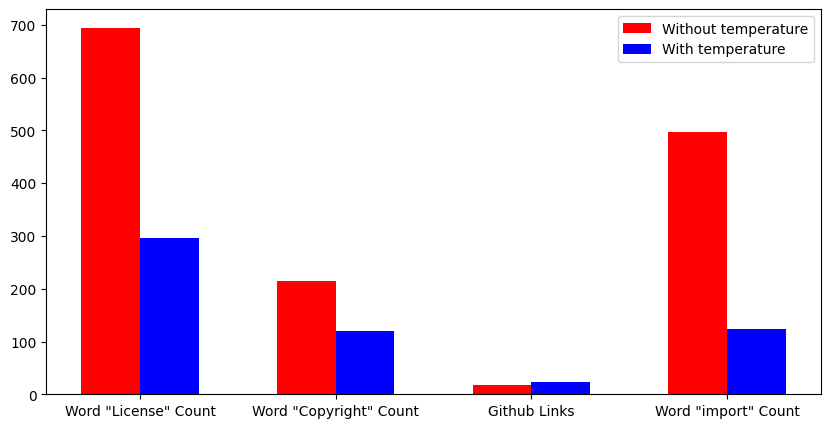

In [11]:
no_temperature = [237 + 116 + 342, 78 + 40 + 96, 3 + 2 + 13, 123 + 236 + 138]
temperature = [78 + 97 + 122, 23 + 47 + 49, 12 + 5 + 6, 68 + 11 + 45]
labels = ['Word \"License\" Count', 'Word \"Copyright\" Count',
          'Github Links', 'Word \"import\" Count']
xx = [x for x in range(4)]

plt.rcParams["figure.figsize"] = (10, 5)
plt.bar(xx, no_temperature, width=0.3, color='r', label='Without temperature')
plt.bar([x + 0.3 for x in xx], temperature, width=0.3, color='b', label='With temperature')
plt.xticks([x + 0.3 / 2 for x in xx], labels)
plt.legend(loc='best')
plt.show()

Regarding github links, approximately half of them found by temperature generation are links to user accounts (most of them are actually valid), while generation without scaled temperature has most of the github links that refer to popular websites (like link to Go or Rust git).

These results show that scaling temperature in generation might be helpful for detecting memorized examples that appear in training data not often (in paper it is called k-eidetic memorization with small k value).

---

# **Inference**

Here is the code to estimate how likely it is that a sentence was present in the training data. In the following example, as expected, all scores are higher for license text than for Shakespeare poem.

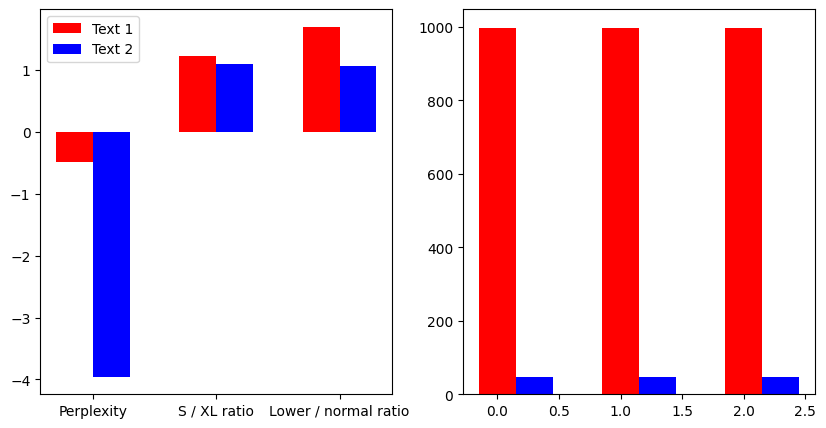

In [13]:
def predict(text1, text2, model1, model2, tokenizer):
    scores = {"XL": [], "S": [], "Lower": [], "zlib": []}
    scores = get_scores([text1, text2], model1, model2, tokenizer, scores)

    fig, axs = plt.subplots(1, 2)

    xx = ['Perplexity', 'S / XL ratio', 'Lower / normal ratio']
    metrics1 = [-np.log(scores["XL"])[0],
               (np.log(scores["S"]) / np.log(scores["XL"]))[0],
               (np.log(scores["Lower"]) / np.log(scores["XL"]))[0],
               (scores["zlib"] / np.log(scores["XL"]))[0]
               ]

    metrics2 = [-np.log(scores["XL"])[1],
               (np.log(scores["S"]) / np.log(scores["XL"]))[1],
               (np.log(scores["Lower"]) / np.log(scores["XL"]))[1],
               (scores["zlib"] / np.log(scores["XL"]))[1]
               ]

    axs[0].bar([x for x in range(3)], metrics1[:3], width=0.3, color='r', label='Text 1')
    axs[0].bar([x + 0.3 for x in range(3)], metrics2[:3], width=0.3, color='b', label='Text 2')
    axs[0].set_xticks([x + 0.3 / 2 for x in range(3)], xx)
    axs[0].legend(loc='best')

    axs[1].bar([x for x in range(3)], metrics1[3], width=0.3, color='r', label='Text 1')
    axs[1].bar([x + 0.3 for x in range(3)], metrics2[3], width=0.3, color='b', label='Text 2')
    plt.show()


texts = ["""//	* Licensed-down below

  *
  * Copyright 2016 <NAME>
  *
  * Licensed under the Apache License, Version 2.0 (the "License");
  * you may not use this file except in compliance with the License.
  * You may obtain a copy of the License at
  *
  *    http://www.apache.org/licenses/LICENSE-2.0
  *
  * Unless required by applicable law or agreed to in writing, software
  * distributed under the License is distributed on an "AS IS" BASIS,
  * WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
  * See the License for the specific language governing permissions and
  * limitations under the License.
  */
  package org.jivesoftware.smack.packet;

  import org.jivesoftware.smack.XMPPException;
  import org.jivesoftware.smack.provider.ProviderManager;
  import org.jivesoftware.smack.serialization.SmackXMLException;
  import org.jivesoftware.smack.util.Objects;
  import org.jivesoftware.sm""",

         """Sir, in my heart there was a kind of fighting
  That would not let me sleep. Methought I lay
  Worse than the mutines in the bilboes. Rashly—
  And prais'd be rashness for it—let us know
  Our indiscretion sometimes serves us well ..."""]

predict(texts[0], texts[1], model1, model2, tokenizer)

# **Some Ideas**
There is a recently published paper where authors claim that it is possible to probe test set contamination in a black box language model (https://arxiv.org/pdf/2310.17623.pdf). They prove that if models' parameters are independent from the data, the log probability of the model should be invariant to permutations of the examples from the dataset. Therefore, in order to test a model for test set contamination, they propose to shuffle samples from dataset N times and compare average log probability of shuffled sequences with the log probability of a sequence with a canonical order.


It seems that this idea might be useful for this task. I conducted a small experiment where a list of generated sentences was shuffled for 20 times and looked at distribution of log probabilities (samples with larger deviation were scored higher). This method detected some of the data that is likely to be a part of a training set (valid github link), but was not detected by other methods. I realize that it is too early to derive conclusions from this experiment, but it might be a potential direction of research on this problem.


---

